## Sentence Window Retrieval

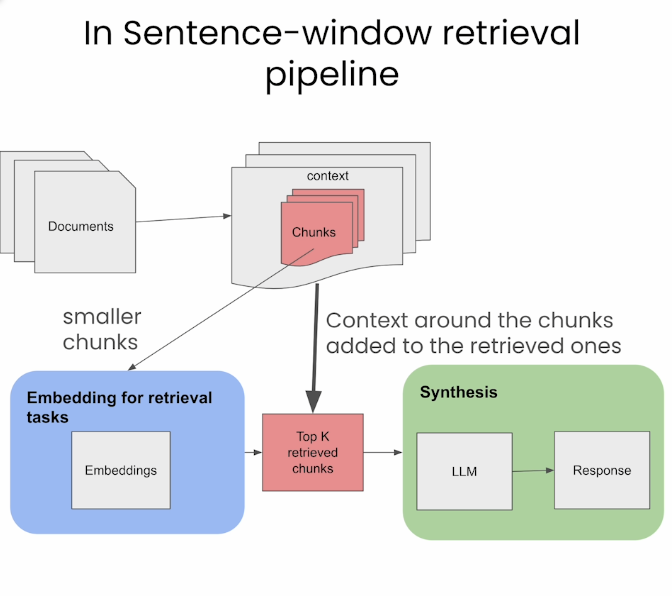

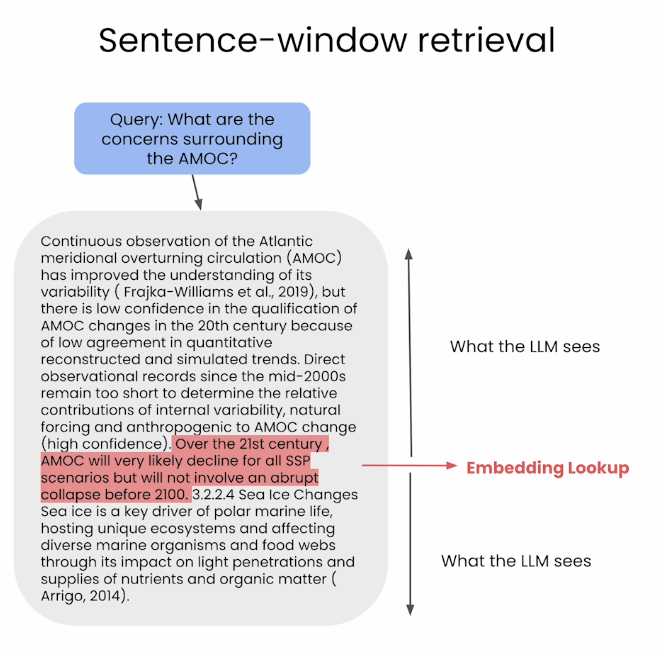

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import openai

import utils

openai.api_key = utils.get_openai_api_key()

✅ In Answer Relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In Answer Relevance, input response will be set to __record__.main_output or `Select.RecordOutput` .
✅ In Context Relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In Context Relevance, input response will be set to __record__.app.query.rets.source_nodes[:].node.text .
✅ In Groundedness, input source will be set to __record__.app.query.rets.source_nodes[:].node.text .
✅ In Groundedness, input statement will be set to __record__.main_output or `Select.RecordOutput` .


In [4]:
from llama_index import SimpleDirectoryReader

documents = SimpleDirectoryReader(
    input_files = ["./data/eBook-How-to-Build-a-Career-in-AI_2.pdf"]
).load_data()

In [5]:
print(type(documents), "\n")
print(len(documents), "\n")
print(type(documents[0]))
print(documents[0])

<class 'list'> 

41 

<class 'llama_index.schema.Document'>
Doc ID: b2073c5d-83f7-43ee-af58-9b62ebbf910b
Text: PAGE 1Founder, DeepLearning.AICollected Insights from Andrew Ng
How to  Build Your Career in AIA Simple Guide


In [6]:
# Merg into a single large document rather than one document per-page
from llama_index import Document

document = Document(text = "\n\n".join([doc.text for doc in documents]))

### Setting up Window-sentence retrieval

In [7]:
from llama_index.node_parser import SentenceWindowNodeParser

node_parser = SentenceWindowNodeParser.from_defaults(
    window_size = 3,
    window_metadata_key = "window",
    original_text_metadata_key = "original_text",
)

In [8]:
# example

text = "Hello, how are you? I am fine! "

nodes = node_parser.get_nodes_from_documents([Document(text = text)])

print([x.text for x in nodes])
print("node : ",nodes[0].metadata['window'])
print("node : ",nodes[1].metadata['window'])

['Hello, how are you? ', 'I am fine! ']
node :  Hello, how are you?  I am fine! 
node :  Hello, how are you?  I am fine! 


In [9]:
# example

text = "Hello. how are you? I am fine. I like dogs. Do you like dogs or cat? "

nodes = node_parser.get_nodes_from_documents([Document(text = text)])

print([x.text for x in nodes])
print("node 0: ",nodes[0].metadata['window'])
print("node 1: ",nodes[1].metadata['window'])
print("node 2: ",nodes[2].metadata['window'])

['Hello. ', 'how are you? ', 'I am fine. ', 'I like dogs. ', 'Do you like dogs or cat? ']
node 0:  Hello.  how are you?  I am fine. 
node 1:  Hello.  how are you?  I am fine.  I like dogs. 
node 2:  Hello.  how are you?  I am fine.  I like dogs.  Do you like dogs or cat? 


### Building the index

In [10]:
from llama_index.llms import OpenAI

llm = OpenAI(model = "gpt-3.5-turbo", temperature = 0.1)

In [11]:
from llama_index import ServiceContext

sentence_context  = ServiceContext.from_defaults(
    llm = llm,
    embed_model = "local:BAAI/bge-small-en-v1.5",
    # embed_model = "local:BAAI/bge-large-en-v1.5"      # bigger model with better performance
    node_parser = node_parser
)

In [12]:
# from llama_index import VectorStoreIndex

# sentence_index = VectorStoreIndex.from_documents(
#     [document], service_context = sentence_context
# )
# sentence_index.storage_context.persist(persist_dir = "./sentence_window_index")

In [13]:
# check if the index file exists or not.
# if not, it will rebuild it

import os
from llama_index import VectorStoreIndex, StorageContext, load_index_from_storage

if not os.path.exists("./sentence_window_index/"):
    sentence_index = VectorStoreIndex.from_documents(
        [document], service_context=sentence_context
    )

    sentence_index.storage_context.persist(persist_dir = "./sentence_window_index/")
else:
    sentence_index = load_index_from_storage(
        StorageContext.from_defaults(persist_dir="./sentence_window_index"),
        service_context=sentence_context
    )

### Building the postprocessor

In [14]:
from llama_index.indices.postprocessor import MetadataReplacementPostProcessor

postproc = MetadataReplacementPostProcessor(
    target_metadata_key = "window"
)

In [15]:
from llama_index.schema import NodeWithScore
from copy import deepcopy

scored_nodes = [NodeWithScore(node= x, score = 1.0) for x in nodes]
nodes_old = [deepcopy(n) for n in nodes]

In [16]:
nodes_old[1].text

'how are you? '

In [17]:
replaced_nodes = postproc.postprocess_nodes(scored_nodes)

In [18]:
print(replaced_nodes[1].text)

Hello.  how are you?  I am fine.  I like dogs. 


## Adding a reranker

In [19]:
from llama_index.indices.postprocessor import SentenceTransformerRerank

# BAAI/bge-reranker-base
# link: https://huggingface.co/BAAI/bge-reranker-base
rerank = SentenceTransformerRerank(
    top_n = 3, model = "BAAI/bge-reranker-base"
)

In [20]:
from llama_index import QueryBundle
from llama_index.schema import TextNode, NodeWithScore

query = QueryBundle("I want a dog.")

scored_nodes = [
    NodeWithScore(node = TextNode(text = "This is a cat"), score = 0.6),
    NodeWithScore(node = TextNode(text = "This is a dog"), score = 0.4),
]

In [21]:
reranked_nodes = rerank.postprocess_nodes(
    scored_nodes, query_bundle = query
)

In [22]:
print([(x.text, x.score) for x in reranked_nodes])

[('This is a dog', 0.91827345), ('This is a cat', 0.0014040713)]
